In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import sys
import PIL as pil
from sklearn import metrics, preprocessing
import cv2
import shap
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_dir = os.path.join('dataset', 'images', 'train_class')
test_dir = os.path.join('dataset', 'images', 'val_class')

In [5]:
img_height = 224
img_width = 224
num_classes = 8
batch_size = 32
CLASSES = ['neutral', 'happy', 'sad', 'surprised', 'fear', 'disgusted', 'angry', 'contempt']

In [6]:
#defining a data generator to have the image in different shape, size and orientation
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  rescale=1./255,
                                  validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.3)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 26288 images belonging to 8 classes.
Found 11265 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


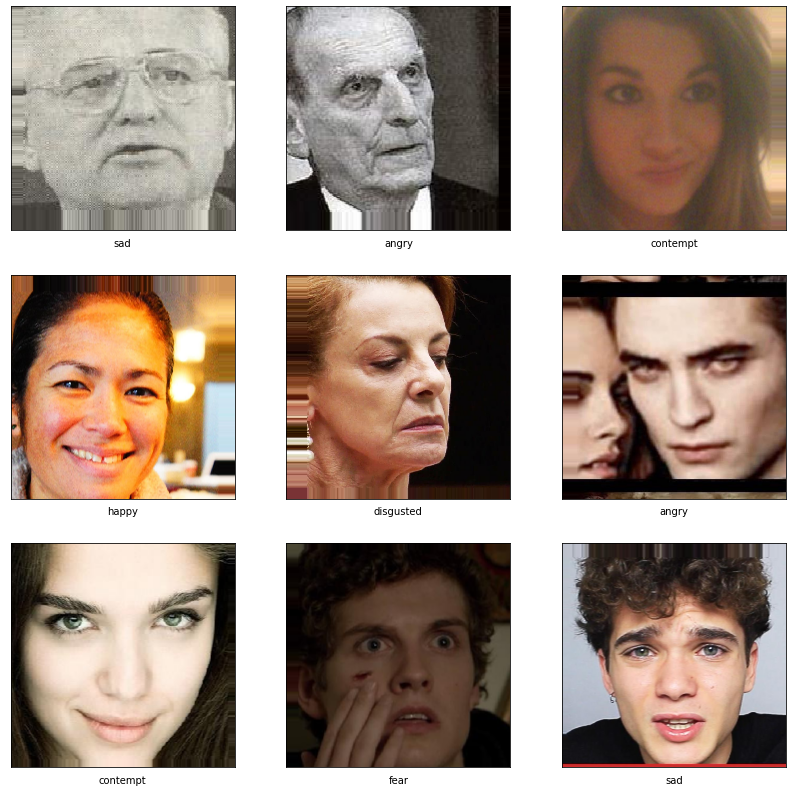

In [7]:
image, classes = next(train_generator)

class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASSES[idx] for idx in class_idxs]

plt.figure(figsize=(14, 14))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((image[i]))
    plt.xlabel(labels[i])
plt.show()

In [8]:
resNet_model = load_model(os.path.join('trained_models', 'resNet50.h5'))

In [9]:
resNet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 8)                 8008      
                                                                 
Total params: 25,644,720
Trainable params: 8,008
Non-trainable params: 25,636,712
_________________________________________________________________


In [10]:
resNet_model.evaluate(test_generator)

125/125 [==============================] - 24s 156ms/step - loss: 1.7044 - accuracy: 0.3368


[1.7043664455413818, 0.33675000071525574]

1/1 [==============================] - 0s 33ms/step


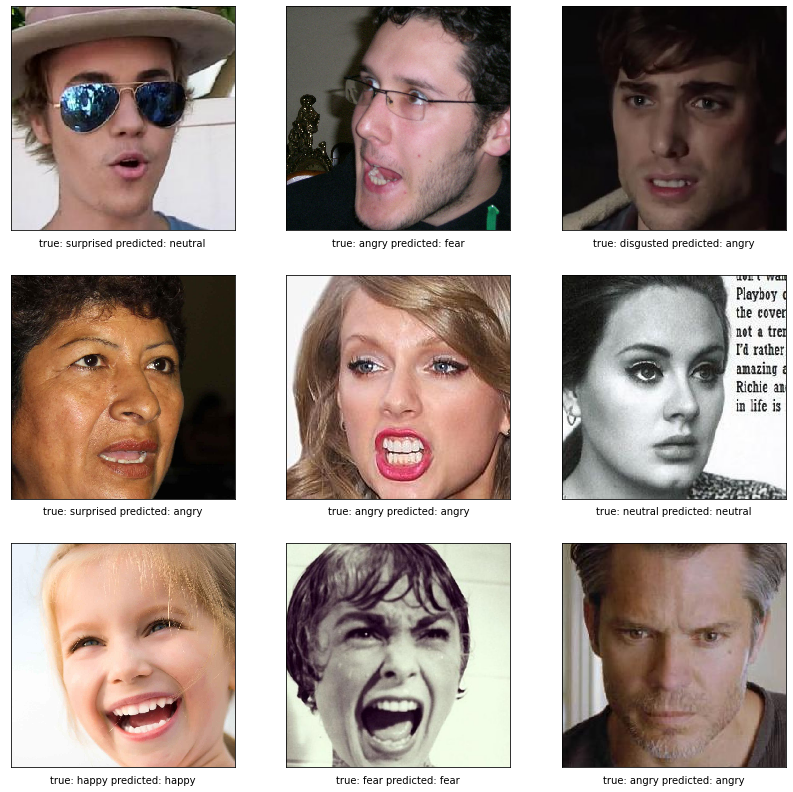

In [45]:
test_image, test_class = next(test_generator)

prediction = resNet_model.predict(test_image)

predictions = np.argmax(prediction, axis = -1)

class_idxs = np.argmax(test_class, axis=-1) 
labels = [CLASSES[idx] for idx in class_idxs]
predictions_label = [CLASSES[idx] for idx in predictions]

plt.figure(figsize=(14, 14))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((test_image[i]))
    plt.xlabel(f'true: {labels[i]} predicted: {predictions_label[i]}', backgroundcolor = 'w')
plt.show()

# Shap

In [55]:
def shap_xai(img):
    def f(X):
        tmp = X.copy()
        #preprocess_input(tmp)
        return resNet_model(tmp)

    masker = shap.maskers.Image("inpaint_telea", test_image[0].shape)

    explainer = shap.Explainer(f, masker, ouput_names = CLASSES)

    shap_values = explainer(img[:1], max_evals=1000, batch_size=16, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values)

## Correct Predictions

  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:19, 19.02s/it]                                                                            


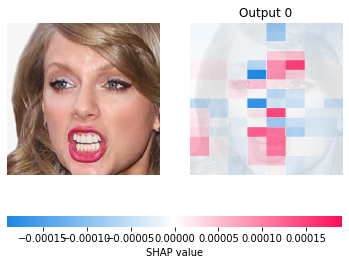

true: angry  predicted: angry


  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:19, 19.76s/it]                                                                            


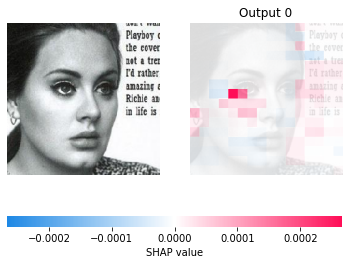

true: neutral  predicted: neutral


  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:16, 16.37s/it]                                                                            


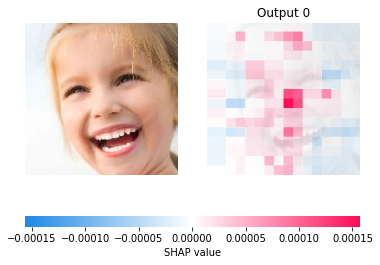

true: happy  predicted: happy


  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:17, 17.77s/it]                                                                            


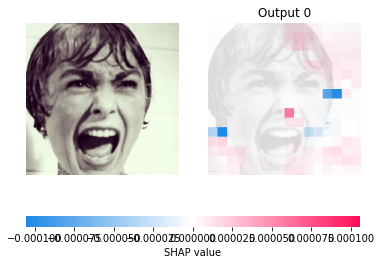

true: fear  predicted: fear


  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:30, 30.51s/it]                                                                            


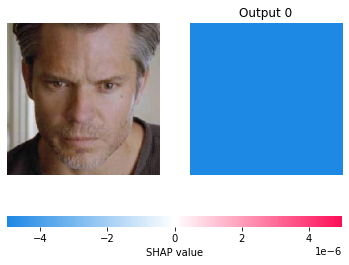

true: angry  predicted: angry


In [46]:
count = 0

for i in range(32):
    if predictions_label[i] == labels[i]:
        shap_xai(test_image[i : i+1])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 5:
            break

## Wrong Predictions

  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:21, 21.51s/it]                                                                            


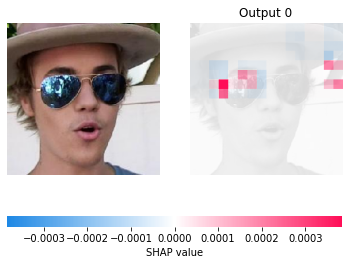

true: surprised  predicted: neutral


  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:30, 30.51s/it]                                                                            


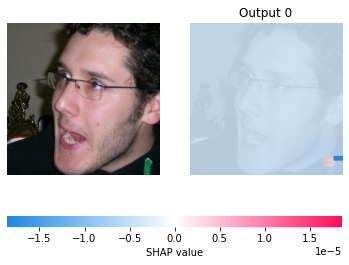

true: angry  predicted: fear


  0%|          | 0/998 [00:00<?, ?it/s]


Partition explainer: 2it [00:30, 30.42s/it]                                                                            


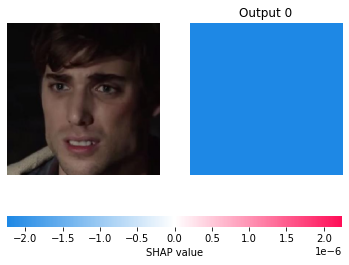

true: disgusted  predicted: angry


In [47]:
count = 0

for i in range(32):
    if predictions_label[i] != labels[i]:
        shap_xai(test_image[i : i+1])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 3:
            break

# Lime

In [51]:
def lime_xai(img):
    explainer_lime = lime_image.LimeImageExplainer()

    explanation = explainer_lime.explain_instance(img.astype('double'), resNet_model.predict, top_labels=8, hide_color=0, num_samples=1000)
    
    print("Masked region of image: ")
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=8, hide_rest=True)
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()
    
    print("A heat of the image for most favoured label: ")
    
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

## Correct Predictions

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


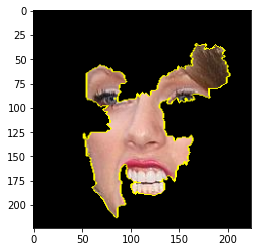

A heat of the image for most favoured label: 


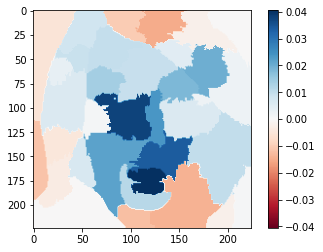

true: angry  predicted: angry


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


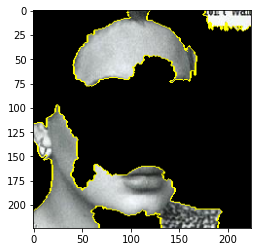

A heat of the image for most favoured label: 


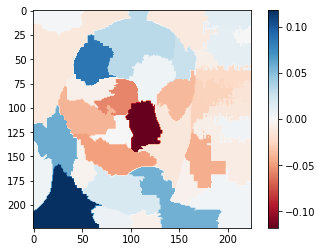

true: neutral  predicted: neutral


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


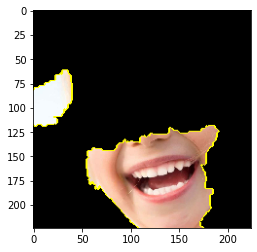

A heat of the image for most favoured label: 


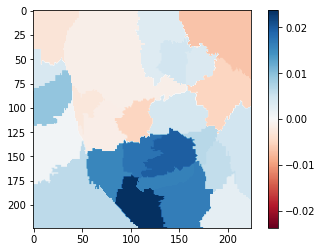

true: happy  predicted: happy


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


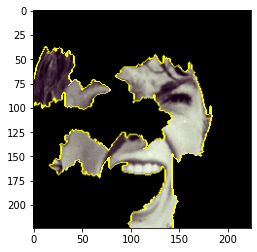

A heat of the image for most favoured label: 


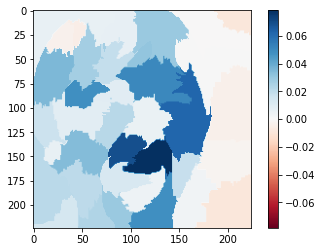

true: fear  predicted: fear


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


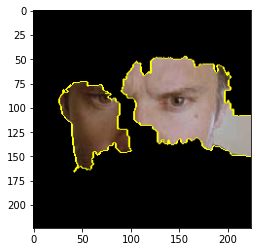

A heat of the image for most favoured label: 


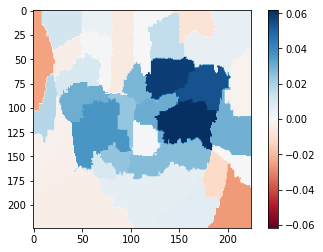

true: angry  predicted: angry


In [53]:
count = 0

for i in range(32):
    if predictions_label[i] == labels[i]:
        lime_xai(test_image[i])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 5:
            break

## Wrong Predictions

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


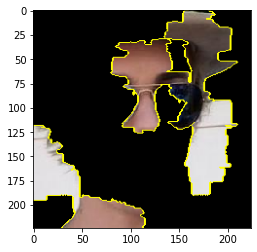

A heat of the image for most favoured label: 


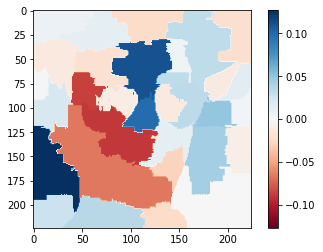

true: surprised  predicted: neutral


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
Masked region of image: 


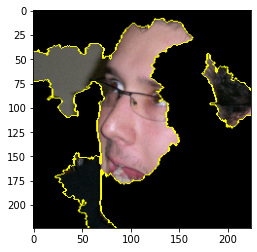

A heat of the image for most favoured label: 


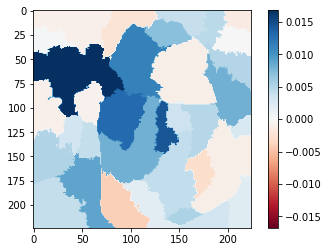

true: angry  predicted: fear


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


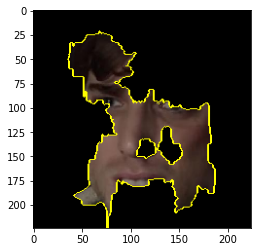

A heat of the image for most favoured label: 


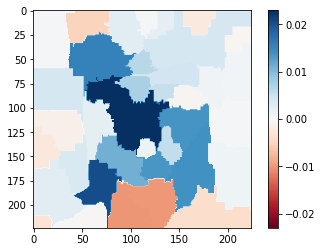

true: disgusted  predicted: angry


In [54]:
count = 0

for i in range(32):
    if predictions_label[i] != labels[i]:
        lime_xai(test_image[i])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 3:
            break